In [8]:
# demo code for real time-series imputation

import data
import torch
import sde
import policy
import numpy as np
from torch.optim import SGD, RMSprop, Adagrad, AdamW, lr_scheduler, Adam
from torch.utils.tensorboard import SummaryWriter
from torch_ema import ExponentialMovingAverage
import matplotlib.pyplot as plt
import runner
from runner import Runner
import util



def build_optimizer_ema_sched(opt, policy):
    direction = policy.direction

    optim_name = {
        'Adam': Adam,
        'AdamW': AdamW,
        'Adagrad': Adagrad, 
        'RMSprop': RMSprop,
        'SGD': SGD,
    }.get(opt.optimizer)

    optim_dict = {
            "lr": opt.lr_f if direction=='forward' else opt.lr_b,
            'weight_decay':opt.l2_norm,
    }
    if opt.optimizer == 'SGD':
        optim_dict['momentum'] = 0.9

    optimizer = optim_name(policy.parameters(), **optim_dict)
    ema = ExponentialMovingAverage(policy.parameters(), decay=0.99)
    if opt.lr_gamma < 1.0:
        sched = lr_scheduler.StepLR(optimizer, step_size=opt.lr_step, gamma=opt.lr_gamma)
    else:
        sched = None

    return optimizer, ema, sched

class arg:
    samp_bs = 2
    # problem_name = 'Scurve'
    problem_name = 'Scurve_condi'
    inner_itr = 2
    mask_update_itr = 1

    condition = True

    hidden_nodes = 56
    
    blocks = 6
    channels = 10
    nheads = 2
    layers = 2

    diff_embed_dim = 128 # embedding dim of diffusion/SDE envolving time-step
    tp_embed_dim = 128 # embedding dim of real time-step/location in time-series
    feature_embed = 40
    side_dim = tp_embed_dim + feature_embed + 1

    # size of multi-var time-series
    K=None
    L=None


    device = 'cuda:0'
    t0 = 0
    T=1
    interval=100
    sde_type = 've'
    noise_type = 'gaussian'
    sigma_min = 0.01
    sigma_max = 2
    forward_net = 'toy'
    backward_net = 'toy'

    optimizer = 'AdamW'
    lr = 1e-4
    lr_f = 1e-4
    lr_b = 1e-4
    lr_gamma = 0.8
    lr_step = 500
    l2_norm = 1e-3
    train_method = 'joint'
    seed = 123
    num_itr = 1000
    eval_itr = 100
    

    

opt = arg()
opt.device
opt.data_dim = [2,100]



In [9]:
with torch.cuda.device(opt.device):
    run = Runner(opt)

    run.sb_joint_train(opt)

build boundary distribution...
build base sde...
build forward policy...
number of parameters is 26803
build backward policy...
number of parameters is 26803
[SB joint] train_it 1/1000 | lr:1.00e-04 | loss:131.0128 | time:0:00:01.28
[SB joint] train_it 2/1000 | lr:1.00e-04 | loss:135.0418 | time:0:00:02.55
[SB joint] train_it 3/1000 | lr:1.00e-04 | loss:125.4284 | time:0:00:03.84
[SB joint] train_it 4/1000 | lr:1.00e-04 | loss:138.7074 | time:0:00:05.14
[SB joint] train_it 5/1000 | lr:1.00e-04 | loss:135.9824 | time:0:00:06.44
[SB joint] train_it 6/1000 | lr:1.00e-04 | loss:125.5915 | time:0:00:07.81
[SB joint] train_it 7/1000 | lr:1.00e-04 | loss:127.2214 | time:0:00:09.11
[SB joint] train_it 8/1000 | lr:1.00e-04 | loss:127.8129 | time:0:00:10.41
[SB joint] train_it 9/1000 | lr:1.00e-04 | loss:125.1138 | time:0:00:11.71
[SB joint] train_it 10/1000 | lr:1.00e-04 | loss:128.8704 | time:0:00:13.00
[SB joint] train_it 11/1000 | lr:1.00e-04 | loss:125.9560 | time:0:00:14.31
[SB joint] trai

KeyboardInterrupt: 

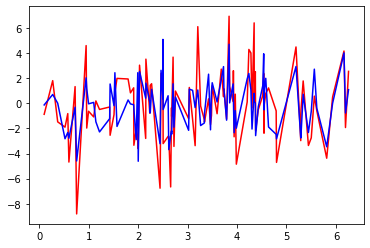

In [10]:
with torch.no_grad():
    ts      = run.ts
    policy_b = run.z_b
    xs_b, _, _ =run.dyn.sample_traj(ts, policy_b, save_traj=True)

plt.plot(run.p.time_step,xs_b[0,0,0,:],'red')
plt.plot(run.p.time_step,xs_b[0,99,0,:],'blue')

# plt.scatter(run.p.time_step,xs_b[0,0,0,:])
# plt.scatter(run.p.time_step,xs_b[0,99,0,:])

# plt.plot(run.p.time_step,run.p.data[0,:],'green')


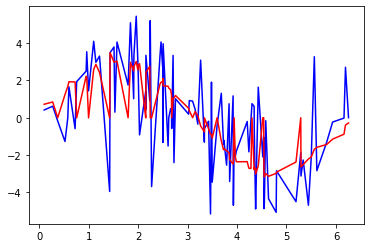

In [11]:
with torch.no_grad():
# plt.plot(run.p.time_step,xs_f[0,0,0,:].detach().numpy() )
    xs_f, zs_f, x_term_f = run.dyn.sample_traj(ts, run.z_f, save_traj=True,update_mask = True)
    plt.plot(run.p.time_step,xs_f[0,99,0,:].detach().numpy(),'blue')
    plt.plot(run.p.time_step,xs_f[0,1,0,:].detach().numpy(),'red')

# plt.plot(run.p.time_step,run.p.data[0,:])

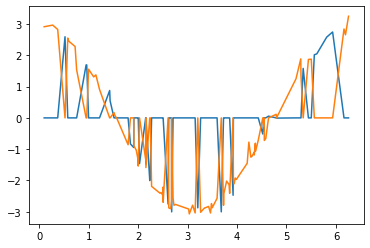

In [19]:

# plt.plot(run.p.time_step,xs_b[0,0,0,:])
# plt.plot(run.p.time_step,run.dyn.x_condi[0,0,:].cpu())
plt.plot(run.p.time_step,run.p.x_condi[1,1,:].cpu())
plt.plot(run.p.time_step,run.p.x_target[1,1,:].cpu())



# plt.plot(run.p.time_step,run.p.data[1,:])

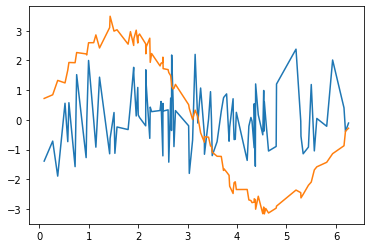

In [7]:
plt.plot(run.p.time_step,xs_b[1,90,0,:])
plt.plot(run.p.time_step,run.p.data[0,:])


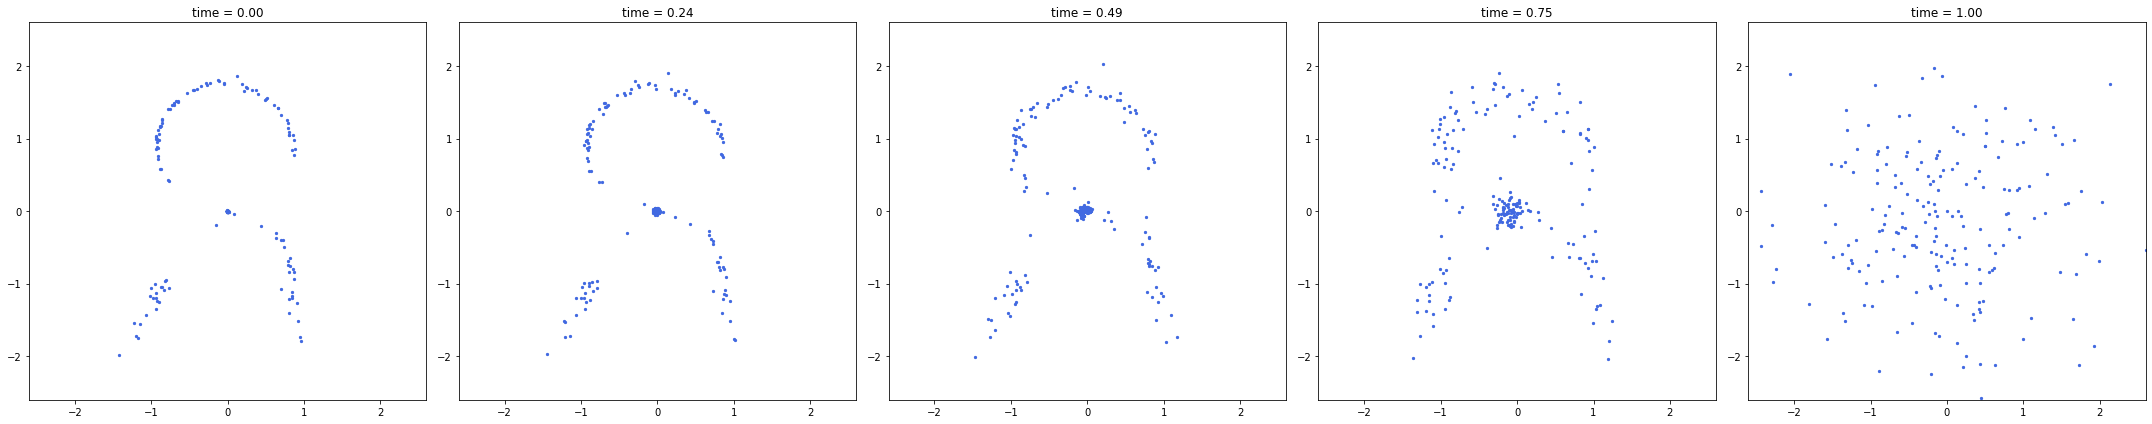

In [11]:
with torch.no_grad():
    ts      = run.ts
    policy_b = run.z_b
    xs_b, _, _ =run.dyn.sample_traj(ts, policy_b, save_traj=True)
direction='backward'
traj = xs_b[0]
n_snapshot = 5
lims = [-2.6, 2.6]

total_steps = traj.shape[1]
sample_steps = np.linspace(0, total_steps-1, n_snapshot).astype(int)
fig, axs = plt.subplots(1, n_snapshot)
fig.set_size_inches(n_snapshot*6, 6)
color = 'salmon' if direction=='forward' else 'royalblue'


idx_target = run.dyn.idx_target

idx_target_sort = np.sort(run.dyn.idx_target)

idx_condi = run.dyn.idx_condi
idx_test =  np.concatenate([np.arange(0,250),np.arange(400,600)])

tarj_condi =  run.p.x_obs[idx_condi]
tarj_test =  run.p.x_obs[idx_test]



for ax, step in zip(axs, sample_steps):

    # ax.scatter(traj[idx_target,step,0],traj[idx_target,step,1], s=5, color=color)
    ax.scatter(traj[idx_target_sort[:200],step,0],traj[idx_target_sort[:200],step,1], s=5, color=color)

    # ax.scatter(traj[idx_condi,step,0],traj[idx_condi,step,1], s=5, color='black')
    

    # ax.scatter(tarj_condi[:,0],tarj_condi[:,1], s=15, color='red')
    # ax.scatter(tarj_test[:,0],tarj_test[:,1], s=15, color='red')


    ax.set_xlim(*lims)
    ax.set_ylim(*lims)
    ax.set_title('time = {:.2f}'.format(step/(total_steps-1)*opt.T))
fig.tight_layout()

In [9]:
idx_target.sort()

In [5]:
def set_valid_condi(dyn,p):
    idx_condi = np.concatenate([np.arange(0,100),np.arange(450,550),np.arange(900,1000)])
    idx_target =  np.concatenate([np.arange(100,450),np.arange(550,900)])
    mask_condi = np.zeros_like(p.x_obs)
    mask_condi[idx_condi,:]=1
    mask_target = 1-mask_condi

    x_target = np.multiply(p.x_obs,1-mask_condi)
    x_condi = np.multiply(p.x_obs,mask_condi)

    dyn.x_condi = torch.Tensor(x_condi).to(opt.device)
    dyn.mask_target = torch.Tensor(mask_target).to(opt.device)
    dyn.idx_target = idx_target
    dyn.idx_condi = idx_condi

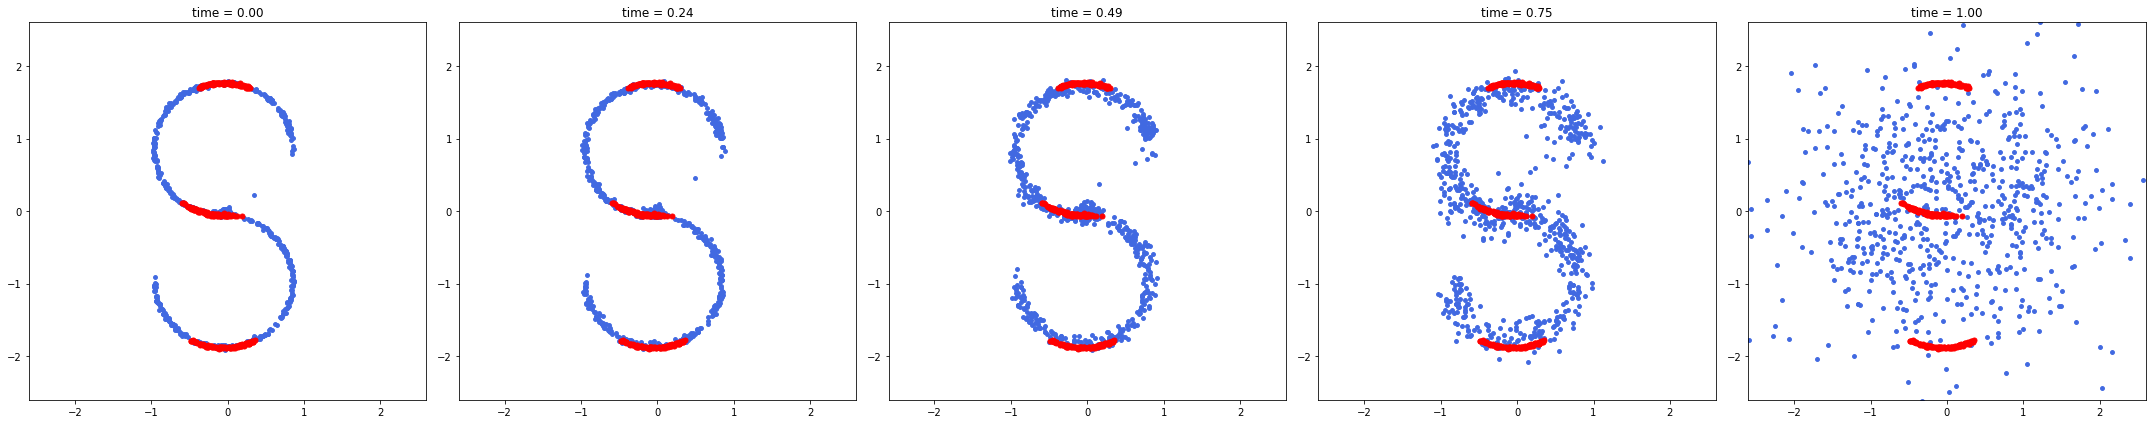

In [6]:



with torch.no_grad():
    ts      = run.ts
    policy_b = run.z_b

    set_valid_condi(run.dyn,run.p)
    
    policy_b.net.set_x_condi(run.dyn.x_condi.repeat(opt.interval,1))

    xs_b, _, _ =run.dyn.sample_traj(ts, policy_b, save_traj=True)

direction='backward'
traj = xs_b
n_snapshot = 5
lims = [-2.6, 2.6]

total_steps = traj.shape[1]
sample_steps = np.linspace(0, total_steps-1, n_snapshot).astype(int)
fig, axs = plt.subplots(1, n_snapshot)
fig.set_size_inches(n_snapshot*6, 6)
color = 'salmon' if direction=='forward' else 'royalblue'


idx_target = run.dyn.idx_target
idx_condi = run.dyn.idx_condi

tarj_condi =  run.p.x_obs[idx_condi]


for ax, step in zip(axs, sample_steps):

    ax.scatter(traj[idx_target,step,0],traj[idx_target,step,1], s=15, color=color)
    # ax.scatter(traj[idx_condi,step,0],traj[idx_condi,step,1], s=5, color='black')
    

    ax.scatter(tarj_condi[:,0],tarj_condi[:,1], s=25, color='red')

    ax.set_xlim(*lims)
    ax.set_ylim(*lims)
    ax.set_title('time = {:.2f}'.format(step/(total_steps-1)*opt.T))
fig.tight_layout()

In [23]:
traj.shape

torch.Size([1000, 100, 2])

In [3]:
# bug-free run test
with torch.cuda.device(opt.device):
    run = Runner(opt)

    policy_f, policy_b = run.z_f, run.z_b
    policy_f = runner.activate_policy(policy_f)
    policy_b = runner.activate_policy(policy_b)
    optimizer_f, _, sched_f = run.get_optimizer_ema_sched(policy_f)
    optimizer_b, _, sched_b = run.get_optimizer_ema_sched(policy_b)

    ts      = run.ts
    batch_x = opt.samp_bs

    optimizer_f.zero_grad()
    optimizer_b.zero_grad()

    xs_f, zs_f, x_term_f = run.dyn.sample_traj(ts, policy_f, save_traj=True)

    # the x_condi is set for forward-z nn during the sample
    # we set it for backward-b nn
    
    

    if opt.condition:
        # policy_b.net.set_x_condi(self.dyn.x_condi.repeat(opt.interval,1)) 
        '''fangL for net_b, we merge the dimention of batch and SDE-time-steps
            to be set back for test? 
         '''
        policy_b.net.set_x_condi(run.dyn.x_condi.repeat(opt.interval,1,1))
        policy_b.net.set_side_info(run.dyn.observed_tp.repeat(opt.interval,1)\
            , run.dyn.mask_condi.repeat(opt.interval,1,1))


    xs_f = util.flatten_dim01(xs_f).to(opt.device)
    zs_f = util.flatten_dim01(zs_f).to(opt.device)
    x_term_f = x_term_f.to(opt.device)
    _ts = ts.repeat(batch_x)

    # loss = runner.compute_sb_nll_joint_train(
    #             opt, batch_x, run.dyn, _ts, xs_f, zs_f, x_term_f, policy_b
    #         )

    # assert opt.train_method == 'joint'
    # assert policy_b.direction == 'backward'
    # assert xs_f.requires_grad and zs_f.requires_grad and x_term_f.requires_grad

    
    # div_gz_b, zs_b = runner.compute_div_gz(opt, run.dyn, _ts, xs_f, policy_b, return_zs=True)
    # loss = 0.5*(zs_f + zs_b)**2 + div_gz_b
    # loss = torch.sum(loss*run.dyn.dt) / batch_x
    # loss = loss - run.dyn.q.log_prob(x_term_f).mean()


    # loss.backward()

build boundary distribution...
build base sde...
build forward policy...
number of parameters is 141442
build backward policy...
number of parameters is 141442
